# LSTM - Univariate - Model - 5 Day - Forecast - Phase - II

In [70]:
import pandas as pd
filtered_df = pd.read_csv('../../data/5day_forecast_2024.csv')

In [71]:
duplicates = filtered_df[filtered_df['date'].duplicated()]
duplicates

,date,pettah_average


In [72]:
# Keep the first occurrence and drop the rest
filtered_df = filtered_df.drop_duplicates(subset=['date'], keep='first')

## Reading Data Set Again from the Excel

In [73]:
# filtered_df = pd.read_excel('../../data/Lstm_Dates.xlsx')
# # Replace all missing values (NaN) in the 'items' column with 'Rice (Rs/kg)_Nadu 2'
# filtered_df['items'] = filtered_df['items'].fillna('Rice (Rs/kg)_Nadu 2')
# filtered_df.head(15)

# Feature Engineering and Final Data Frame Creation

## Use Interpolation to Fill Missing Values

In [74]:
# Time-based interpolation (useful for datetime indices)
filtered_df['pettah_average'] = filtered_df['pettah_average'].interpolate(method='linear', limit_direction='both')
filtered_df.head(15)

,date,pettah_average
0,5/31/2019,84.000000
1,6/1/2019,84.000000
2,6/2/2019,84.000000
3,6/3/2019,84.000000
4,6/4/2019,83.333333
5,6/5/2019,82.666667
6,6/6/2019,82.000000
7,6/7/2019,81.000000
8,6/8/2019,80.933333
9,6/9/2019,80.866667


## Plotting the Pettah Average Price

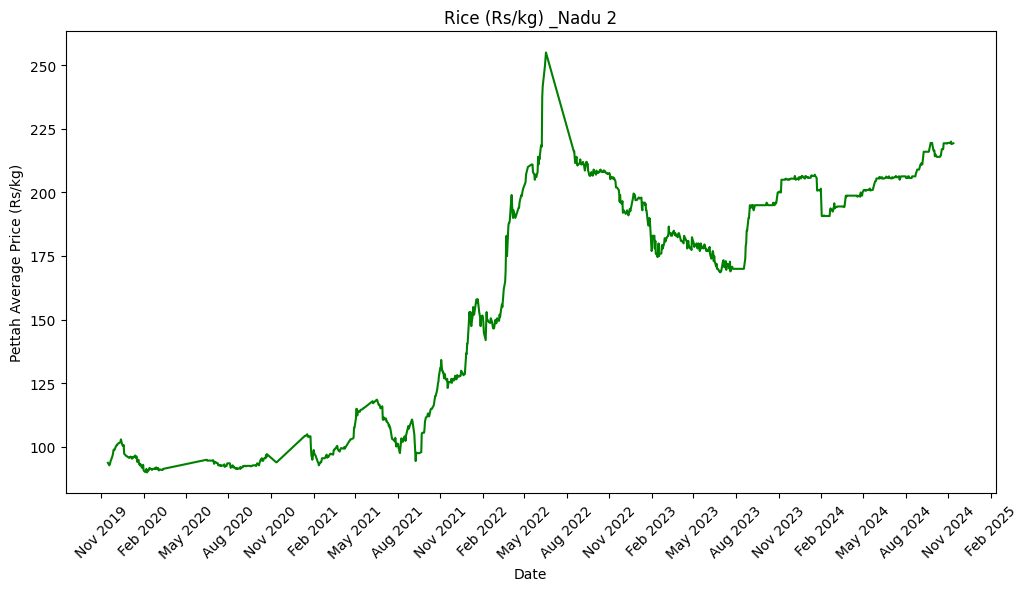

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

filtered_df['date'] = pd.to_datetime(filtered_df['date'])

latest_data = filtered_df[-1825:].reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot pettah_average over time
sns.lineplot(data=latest_data, x='date', y='pettah_average', ax=ax, color='green')

# Add titles and labels
ax.set_title('Rice (Rs/kg) _Nadu 2')
ax.set_xlabel('Date')
ax.set_ylabel('Pettah Average Price (Rs/kg)')

# Set x-axis format to show the month and year (e.g., Jan 2024)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the interval for x-axis ticks to every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# Rotate date labels for better readability
plt.xticks(rotation=45)

# latest_data.to_csv('forecast_2024.csv', index=False)

# Show the plot
plt.show()

In [76]:
print(filtered_df.columns)

Index(['date', 'pettah_average'], dtype='object')


## Time Series Decomposition - Additive Model

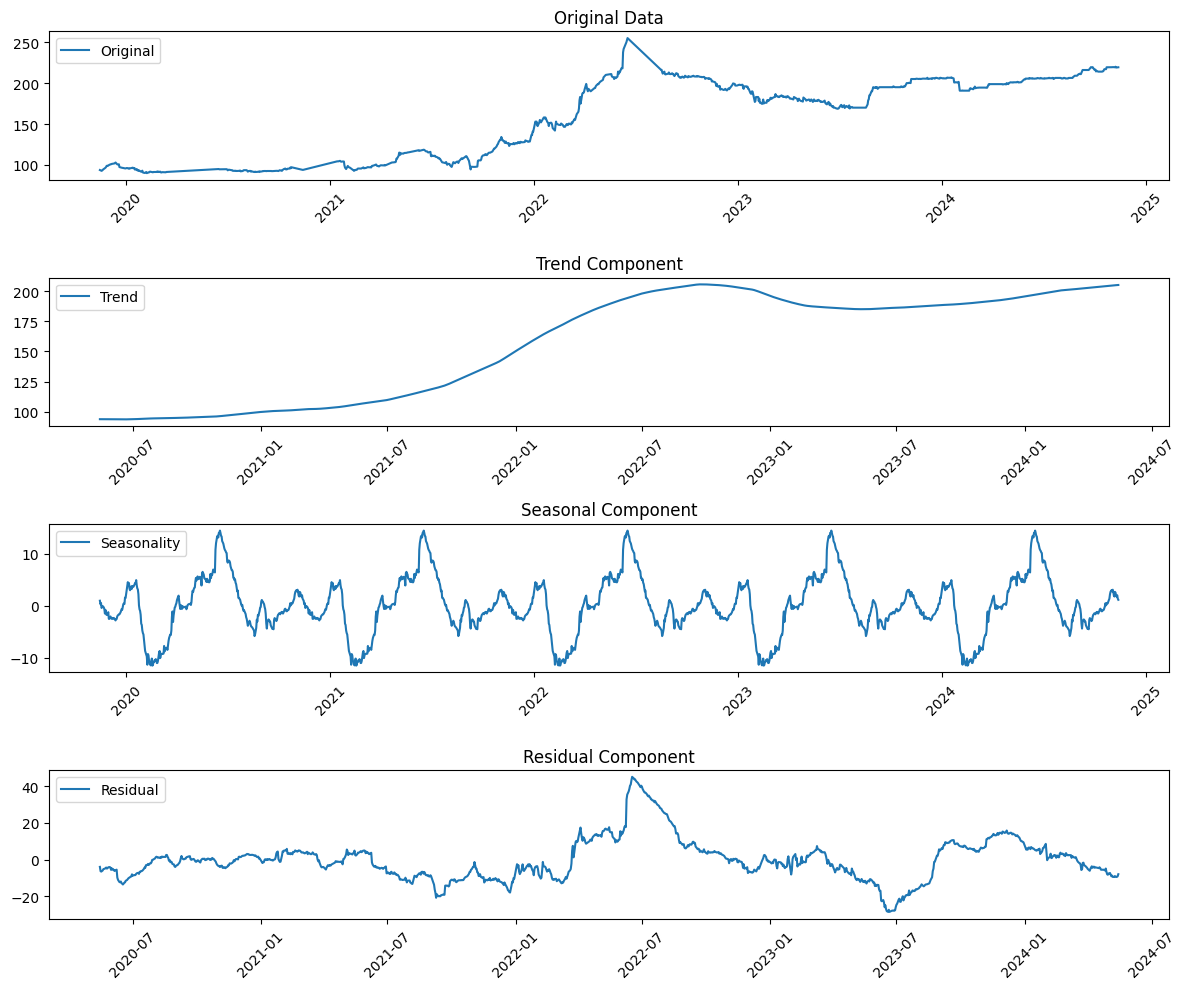

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose

filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Filter the latest 1825 data points
latest_data = filtered_df[-1825:]

# Set index to 'date' column
latest_data.set_index('date', inplace=True)

# Perform seasonal decomposition (additive model is often used for price data)
decomposition = seasonal_decompose(latest_data['pettah_average'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(latest_data['pettah_average'], label='Original')
plt.title('Original Data')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.title('Seasonal Component')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual Component')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Non-Stationary Time Series

A time series is non-stationary if its statistical properties change over time. In other words, a non-stationary series may have:

- Trends: The mean of the series may increase or decrease over time.
- Changing Variance: The spread around the mean may increase or decrease over time.
- Seasonality: The series may show repeating patterns or cycles at regular intervals.
- Autocovariance Depends on Time: The covariance between points can change depending on the specific time period.

## Data Transformation

### Box - Cox Transform

In [78]:
from scipy.stats import boxcox

# Apply Box-Cox Transformation
latest_data['pettah_average'], lambda_value = boxcox(latest_data['pettah_average'])

# Print the lambda used for the transformation
print(f"Lambda value: {lambda_value}")

Lambda value: 0.6969696416178247


C:\Users\VenuraP\AppData\Local\Temp\ipykernel_3988\1942972102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['pettah_average'], lambda_value = boxcox(latest_data['pettah_average'])


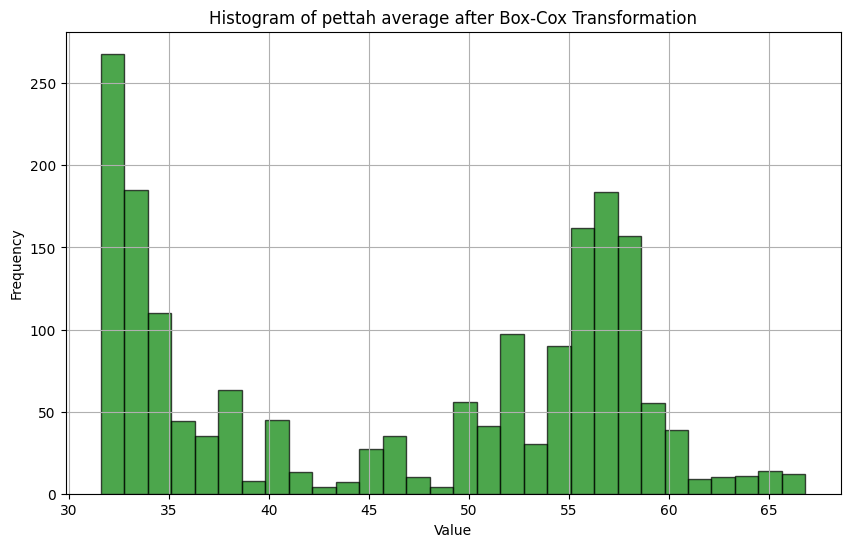

In [79]:
plt.figure(figsize=(10, 6))  # Optional: set the figure size
plt.hist(latest_data['pettah_average'], bins=30, alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram of pettah average after Box-Cox Transformation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True) 
plt.show()

## Data Scaling

### Min-Max Scaling

In [80]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(latest_data)

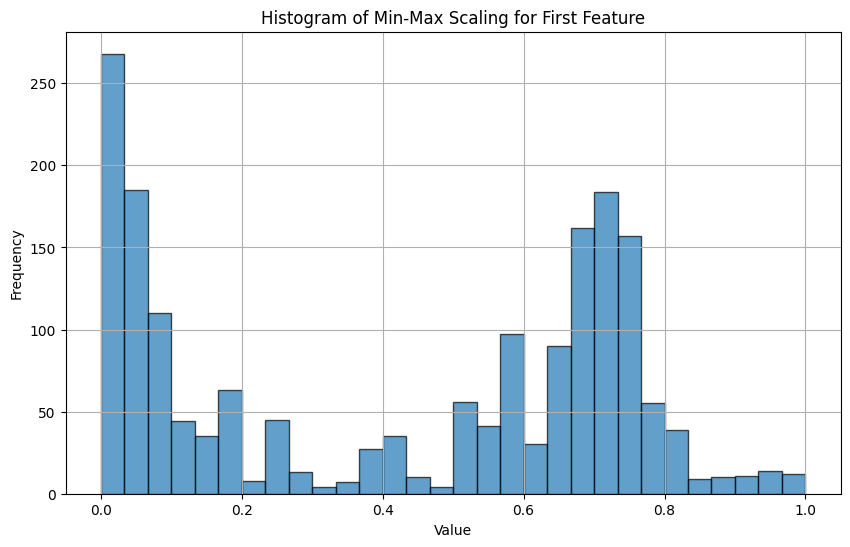

In [81]:
import matplotlib.pyplot as plt

# Plot histogram for the first feature only
plt.figure(figsize=(10, 6))
plt.hist(scaled_data[:, 0], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Min-Max Scaling for First Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Remove the Zero Values in the Scaled_df

In [82]:
# Identify rows that have any '0' values
rows_with_zeros = (scaled_data == 0).any(axis=1)

# Filter out those rows (keep only rows without '0' values)
scaled_data = scaled_data[~rows_with_zeros]

## Train / Test Split 

## 5 Day Forecast Sequence Creation

In [83]:
import numpy as np

date_index = latest_data.index

# Define sequence length and forecast horizon
sequence_length = 30
forecast_horizon = 5

# Initialize lists for sequences, labels, and corresponding dates
sequences, labels, seq_dates, label_dates = [], [], [], []

# Create sequences and labels iteratively
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    # Create sequence of 30 elements
    seq = scaled_data[i:i + sequence_length]
    # Create label of the next 5 values
    label = scaled_data[i + sequence_length:i + sequence_length + forecast_horizon, 0]
    
    # Record corresponding dates
    seq_date = date_index[i:i + sequence_length]
    label_date = date_index[i + sequence_length:i + sequence_length + forecast_horizon]
    
    # Append to lists
    sequences.append(seq)
    labels.append(label)
    seq_dates.append(seq_date)
    label_dates.append(label_date)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into training and testing
train_x, test_x = sequences[:-1], sequences[-1:]
train_y, test_y = labels[:-1], labels[-1:]
train_x_dates, test_x_dates = seq_dates[:-1], seq_dates[-1]
train_y_dates, test_y_dates = label_dates[:-1], label_dates[-1]

# Debugging Outputs
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)
print("Test Forecast Dates:", test_y_dates)

# Print the last 5 training dates for verification
print("\nLast 5 Training Dates:")
for idx, date_range in enumerate(train_x_dates[-5:]):
    print(f"Sequence {idx + 1}: {date_range[0]} to {date_range[-1]}")

Train X shape: (1789, 30, 1)
Train Y shape: (1789, 5)
Test X shape: (1, 30, 1)
Test Y shape: (1, 5)
Test Forecast Dates: DatetimeIndex(['2024-11-07', '2024-11-08', '2024-11-09', '2024-11-10',
               '2024-11-11'],
              dtype='datetime64[ns]', name='date', freq=None)

Last 5 Training Dates:
Sequence 1: 2024-10-03 00:00:00 to 2024-11-01 00:00:00
Sequence 2: 2024-10-04 00:00:00 to 2024-11-02 00:00:00
Sequence 3: 2024-10-05 00:00:00 to 2024-11-03 00:00:00
Sequence 4: 2024-10-06 00:00:00 to 2024-11-04 00:00:00
Sequence 5: 2024-10-07 00:00:00 to 2024-11-05 00:00:00


## Model

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Bidirectional, Attention
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Create the LSTM model
model = Sequential()

# Conv1D layers for pattern extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=7, activation='relu'))  # Larger kernel for weekly patterns
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(Dropout(0.2))

# LSTM layers for sequential modeling
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dropout(0.2))

# Dense layers for abstraction
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

# Final dense layer for the 7-day forecast
model.add(Dense(units=5, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\VenuraP\AppData\Local\anaconda3\envs\hartipredict\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Bidirectional, Attention,Flatten
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Input layer
# input_layer = Input(shape=(train_x.shape[1], train_x.shape[2]))

# # Conv1D layers for pattern extraction
# x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
# x = Dropout(0.2)(x)

# x = Conv1D(filters=128, kernel_size=7, activation='relu')(x)  # Larger kernel for weekly patterns
# x = Dropout(0.2)(x)

# x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
# x = Dropout(0.2)(x)

# # LSTM layers for sequential modeling
# x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
# x = Dropout(0.2)(x)

# x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
# x = Dropout(0.2)(x)

# # Attention layer
# attention_output = Attention()([x, x])  # Query and value are the same
# x = Dropout(0.2)(attention_output)

# # Flatten the output after the attention layer
# x = Flatten()(x)

# # Dense layers for abstraction
# x = Dense(units=256, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.3)(x)

# x = Dense(units=128, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.3)(x)

# # Flatten the output to fit the Dense layer for the 7-day forecast
# x = Dense(units=7, activation='linear')(x)

# # Create the model
# model = Model(inputs=input_layer, outputs=x)

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Print the model summary
# model.summary()

## Model-Conv1D and Bidirectional LSTM Layers

In [86]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 22, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 18, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 18, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 18, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,861 (2.42 MB)

 Trainable params: 633,861 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

### Hyperparameter Tuning

In [87]:
# # Define callbacks
# # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# # patience = patience=5: Number of epochs to wait for improvement in validation loss before stopping. If validation loss does not improve for 5 consecutive epochs, training will stop
model_checkpoint = ModelCheckpoint('models/Nadu_2_prediction/5 Day Model/5day_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[model_checkpoint] 
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.1050 - val_loss: 0.0019
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0191 - val_loss: 0.0046
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0148 - val_loss: 0.0059
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0122 - val_loss: 0.0014
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0098 - val_loss: 4.8376e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0087 - val_loss: 0.0017
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0081 - val_loss: 0.0140
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/

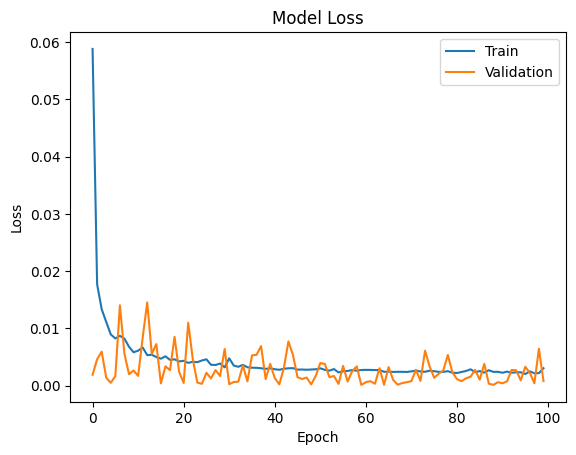

In [88]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

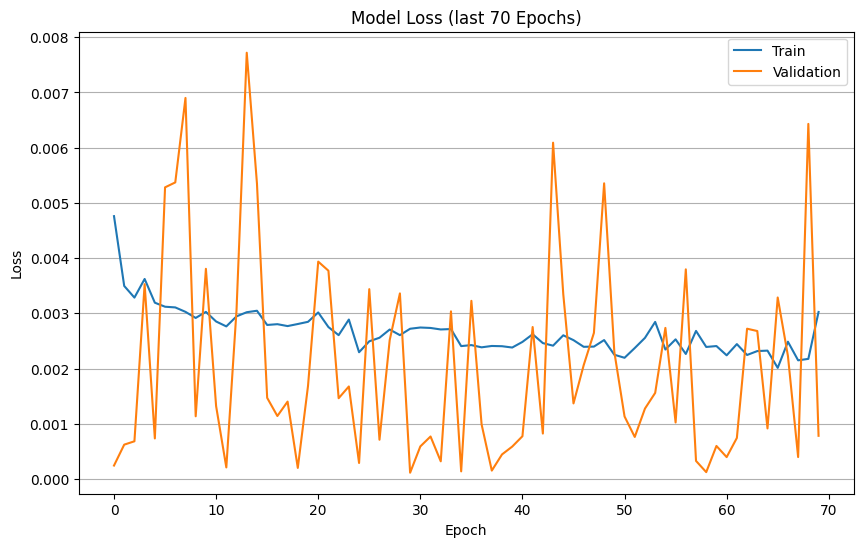

In [89]:
import matplotlib.pyplot as plt

# Get the total number of epochs
total_epochs = len(history.history['loss'])

# Define the range for the 70 epochs
last_70_epochs = range(min(70, total_epochs))

# Slice the loss and validation loss for the last 70 epochs
loss = history.history['loss'][-70:]
val_loss = history.history['val_loss'][-70:]

# Plot training & validation loss values for the last 70 epochs
plt.figure(figsize=(10, 6))
plt.plot(last_70_epochs, loss)
plt.plot(last_70_epochs, val_loss)
plt.title('Model Loss (last 70 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Add horizontal grid lines
plt.grid(axis='y')

plt.show()

## Error Analysis on Training Set 

In [90]:
# High level evaluation on test set loss Evaluate the best model on the test set
import tensorflow as tf
best_model = tf.keras.models.load_model('models/Nadu_2_prediction//5 Day Model/5day_model.keras')

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predictions_train = best_model.predict(train_x)

# Calculate evaluation metrics
r2 = r2_score(train_y, predictions_train)
mae = mean_absolute_error(train_y, predictions_train)
mse = mean_squared_error(train_y, predictions_train)
rmse = np.sqrt(mse)

print("Train R-squared:", r2)
print("Train Mean Absolute Error (MAE):", mae)
print("Train set Mean Squared Error (MSE):", mse)
print("Train set Root Mean Squared Error (RMSE):", rmse)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Train R-squared: 0.995285913349068
Train Mean Absolute Error (MAE): 0.012778147430823885
Train set Mean Squared Error (MSE): 0.00044994184224589286
Train set Root Mean Squared Error (RMSE): 0.021211832599893222


## Error analysis on Test Set

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict temperatures using the trained model
predictions_test = best_model.predict(test_x)

# Calculate evaluation metrics
r2 = r2_score(test_y, predictions_test)
mae = mean_absolute_error(test_y, predictions_test)
mse = mean_squared_error(test_y, predictions_test)
rmse = np.sqrt(mse)

print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R-squared: nan
Mean Absolute Error (MAE): 0.002318803813092951
Mean Squared Error (MSE): 6.246449815186088e-06
Root Mean Squared Error (RMSE): 0.0024992898621780725


c:\Users\VenuraP\AppData\Local\anaconda3\envs\hartipredict\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


- MSE is sensitive to outliers in the data when MSE is high
- RMSE also same sensitive to lager erros but this is good since the units are same as the data ( Rs and error also Rs)

## Prediction on Test Set

In [93]:
prediction = best_model.predict(test_x)  # Shape: (num_samples, timesteps=sequence_length, features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


## Inverse Transformation on Test set and Predictions ( Scalers -->Transformers-->Actual Prices)

In [94]:
from scipy.special import inv_boxcox

# Inverse transformation for test_y
true_prices = []
for row in test_y:
    # Reshape each row to the scaler's feature shape and inverse transform
    row_copies = np.repeat(row.reshape(-1, 1), test_x.shape[-1], axis=-1)
    # Apply inverse scaling and Box-Cox
    row_true_price = scaler.inverse_transform(row_copies)[:, 0]  # Keep only the first feature's original values min-max scaling
    row_true_price = inv_boxcox(row_true_price, lambda_value)    # Apply Box-Cox inverse
    true_prices.append(row_true_price)

# Convert list back to a numpy array
true_prices = np.array(true_prices)

# Inverse transformation for predictions
predicted_prices = []
for row in prediction:
    # Reshape each row to match the scaler's shape and inverse transform
    row_copies = np.repeat(row.reshape(-1, 1), test_x.shape[-1], axis=-1)
    # Apply inverse scaling and Box-Cox
    row_predicted_price = scaler.inverse_transform(row_copies)[:, 0] # Keep only the first feature's original values min-max scaling
    row_predicted_price = inv_boxcox(row_predicted_price, lambda_value) # Apply Box-Cox inverse
    predicted_prices.append(row_predicted_price)

# Convert list back to a numpy array
predicted_prices = np.array(predicted_prices)

DatetimeIndex(['2024-11-07', '2024-11-08', '2024-11-09', '2024-11-10',
               '2024-11-11'],
              dtype='datetime64[ns]', name='date', freq=None)
[219.     219.0825 219.165  219.2475 219.33  ]
[218.52562 218.88037 219.4011  218.65933 218.74033]
Forecast Dates: DatetimeIndex(['2024-11-07', '2024-11-08', '2024-11-09', '2024-11-10',
               '2024-11-11'],
              dtype='datetime64[ns]', name='date', freq=None)
True Prices: [219.     219.0825 219.165  219.2475 219.33  ]
Predicted Prices: [218.52562 218.88037 219.4011  218.65933 218.74033]
Shapes - Forecast Dates: 5 True Prices: (5,) Predicted Prices: (5,)


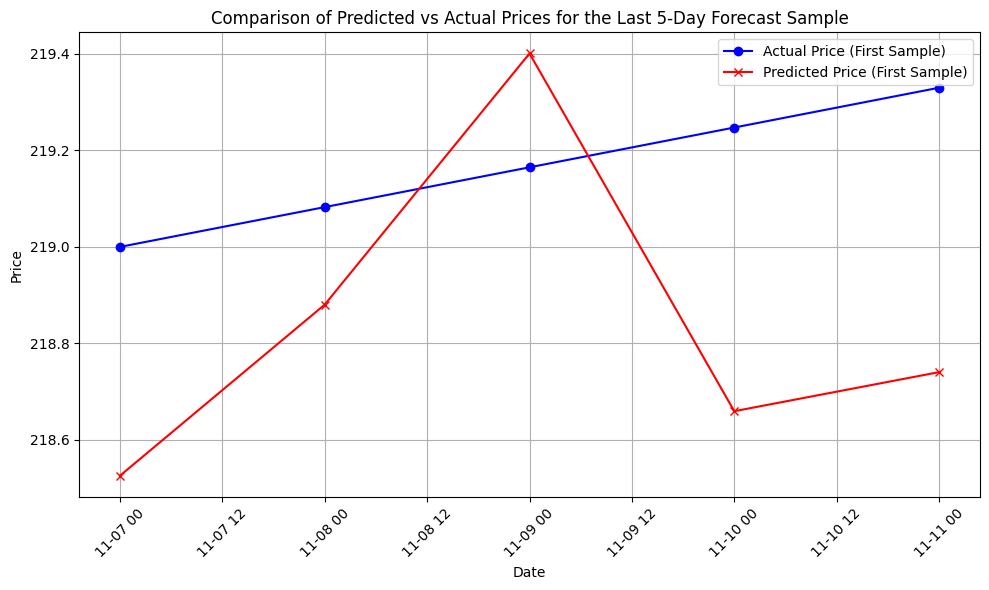

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the first and only forecast period from `test_y` and `test_dates`
forecast_dates = test_y_dates  # Already contains the last 5 dates
sample_true = true_prices[0]  # Extract the single 5-day true price values
sample_pred = predicted_prices[0]  # Extract the single 5-day predicted values

print(forecast_dates)
print(sample_true)
print(sample_pred)

# Ensure forecast_dates is in a compatible format
if isinstance(forecast_dates, (np.ndarray, pd.Series)):
    forecast_dates = forecast_dates.tolist()

# Debugging: Print dimensions and content
print("Forecast Dates:", forecast_dates)
print("True Prices:", sample_true)
print("Predicted Prices:", sample_pred)
print("Shapes - Forecast Dates:", len(forecast_dates),
      "True Prices:", sample_true.shape,
      "Predicted Prices:", sample_pred.shape)

# Check dimensions for consistency
if len(forecast_dates) != len(sample_true) or len(forecast_dates) != len(sample_pred):
    raise ValueError(
        f"Mismatch in dimensions: forecast_dates ({len(forecast_dates)}) vs "
        f"true prices ({len(sample_true)}) or predicted prices ({len(sample_pred)})"
    )

# Plotting
plt.figure(figsize=(10, 6))

# Plot true and predicted prices
plt.plot(forecast_dates, sample_true, label='Actual Price (First Sample)', marker='o', color='blue')
plt.plot(forecast_dates, sample_pred, label='Predicted Price (First Sample)', marker='x', color='red')

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of Predicted vs Actual Prices for the Last 5-Day Forecast Sample")
plt.legend()
plt.grid(True)

# Rotate dates on x-axis for readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

##  Heatmap of Prediction Errors

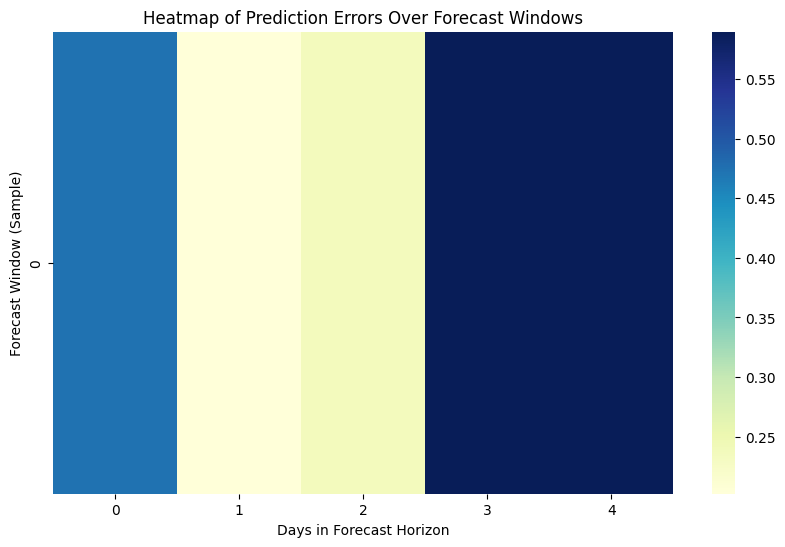

In [96]:
import seaborn as sns
import numpy as np

# Calculate error matrix
errors = np.abs(true_prices - predicted_prices)  # Absolute error for each day in the forecast

plt.figure(figsize=(10, 6))
sns.heatmap(errors, cmap="YlGnBu", annot=False)
plt.xlabel("Days in Forecast Horizon")
plt.ylabel("Forecast Window (Sample)")
plt.title("Heatmap of Prediction Errors Over Forecast Windows")
plt.show()


## Scatter Plot of Predicted vs Actual Values

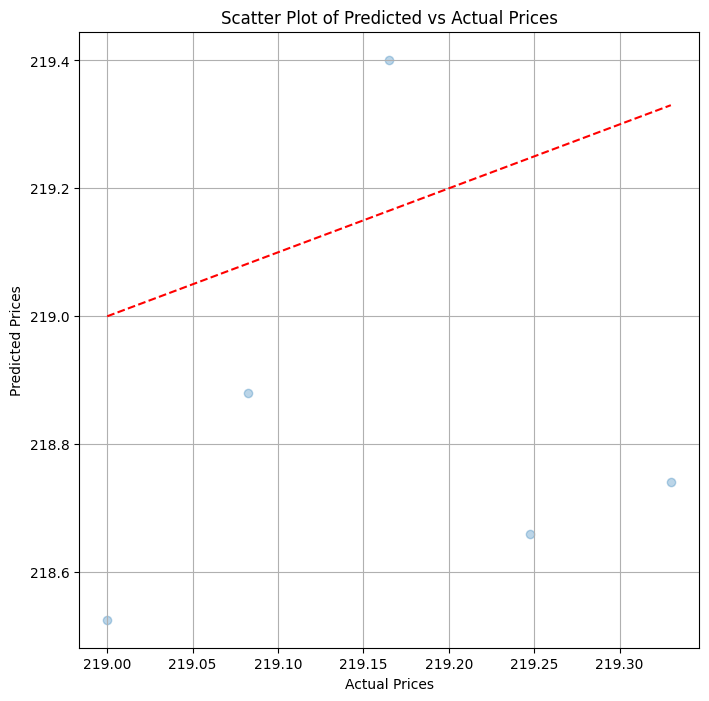

In [97]:
plt.figure(figsize=(8, 8))
plt.scatter(true_prices.flatten(), predicted_prices.flatten(), alpha=0.3)
plt.plot([min(true_prices.flatten()), max(true_prices.flatten())], [min(true_prices.flatten()), max(true_prices.flatten())], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Scatter Plot of Predicted vs Actual Prices")
plt.grid(True)
plt.show()


##  Mean Absolute Error (MAE) or Mean Squared Error (MSE) Over Time

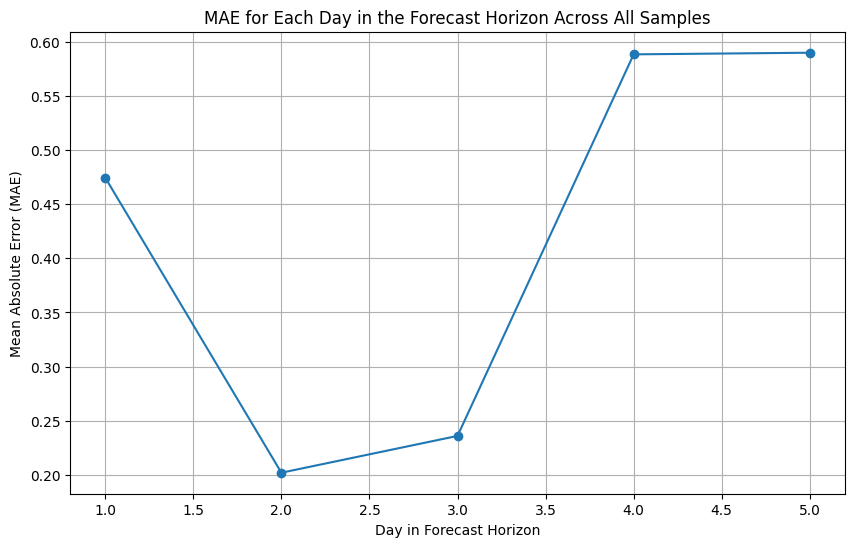

In [98]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each day in the 5-day forecast window across all samples
mae_per_day = [mean_absolute_error(true_prices[:, i], predicted_prices[:, i]) for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), mae_per_day, marker='o')
plt.xlabel("Day in Forecast Horizon")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE for Each Day in the Forecast Horizon Across All Samples")
plt.grid(True)
plt.show()
